<a href="https://colab.research.google.com/github/DastanIqbal/LearnOpenCV/blob/main/src/OpenCV/dlap/week5/FineTuneImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine Tunning**

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import os,shutil


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.1


In [2]:
!pip install kaggle

**Load Dataset**

In [3]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sriramr/apples-bananas-oranges

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes
Dataset URL: https://www.kaggle.com/datasets/sriramr/apples-bananas-oranges
License(s): unknown
100% 511M/512M [00:29<00:00, 18.8MB/s]
100% 512M/512M [00:29<00:00, 18.4MB/s]


In [12]:
# !rm -rf original_data_set
# !rm -rf fruits
!unzip -q apples-bananas-oranges.zip

In [13]:
main_path = 'original_data_set/original_data_set/'

In [14]:
classnames = os.listdir(main_path)
print(classnames)

['rottenapples', 'freshbanana', 'freshoranges', 'rottenoranges', 'freshapples', 'rottenbanana']


In [15]:
for each_class in classnames:
  print("Class: {}, has {} samples".format(each_class, len(os.listdir(os.path.join(main_path, each_class)))))

Class: rottenapples, has 328 samples
Class: freshbanana, has 218 samples
Class: freshoranges, has 206 samples
Class: rottenoranges, has 222 samples
Class: freshapples, has 232 samples
Class: rottenbanana, has 306 samples


**Arrange your Data** (15% Validation 85% folder)

In [16]:
base_dir = 'fruits'

total_train_images = 0
total_val_images = 0

os.mkdir(base_dir)
train_dir = os.path.join(base_dir,'train')
os.mkdir(train_dir)

validation_dir = os.path.join(base_dir,'validation')
os.mkdir(validation_dir)

validation_percent = 15

for each_class in classnames:

  source_directory = os.path.join(main_path,each_class)
  destination_train_directory = os.path.join(train_dir, each_class)
  destination_validation_directory = os.path.join(validation_dir, each_class)

  total_image_count = len(os.listdir(source_directory))

  valid_image_count = int(np.floor(total_image_count * (validation_percent/100)))

  train_image_count = int(total_image_count - valid_image_count)

  total_train_images += train_image_count
  total_val_images += valid_image_count

  os.mkdir(destination_train_directory)
  os.mkdir(destination_validation_directory)

  file_names = os.listdir(source_directory)[:train_image_count]

  for fname in file_names:
    src = os.path.join(source_directory, fname)
    dst = os.path.join(destination_train_directory, fname)
    shutil.copyfile(src, dst)

  file_names = os.listdir(source_directory)[train_image_count:]

  for fname in file_names:
    src = os.path.join(source_directory,fname)
    dst = os.path.join(destination_validation_directory, fname)
    shutil.copyfile(src, dst)

  print("total training {} images: {}".format(each_class, len(os.listdir(destination_train_directory))))
  print("total validation {} images: {}".format(each_class, len(os.listdir(destination_validation_directory))))



total training rottenapples images: 279
total validation rottenapples images: 49
total training freshbanana images: 186
total validation freshbanana images: 32
total training freshoranges images: 176
total validation freshoranges images: 30
total training rottenoranges images: 189
total validation rottenoranges images: 33
total training freshapples images: 198
total validation freshapples images: 34
total training rottenbanana images: 261
total validation rottenbanana images: 45


**Freeze the required layers**

Experiment 1: Freezing all layers - Same as Transfer Learning




In [17]:
from tensorflow.keras.applications import VGG16

image_size = 224

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [62]:
# Load the VGG model
vgg_conv = VGG16(weights = 'imagenet', include_top = False, input_shape = (image_size,image_size, 3))

for layer in vgg_conv.layers[:]:
  layer.trainable = False

for layer in vgg_conv.layers:
  print(layer, layer.trainable)


model = models.Sequential()

model.add(vgg_conv)

model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classnames), activation = 'softmax'))

model.summary()


<InputLayer name=input_layer_9, built=True> False
<Conv2D name=block1_conv1, built=True> False
<Conv2D name=block1_conv2, built=True> False
<MaxPooling2D name=block1_pool, built=True> False
<Conv2D name=block2_conv1, built=True> False
<Conv2D name=block2_conv2, built=True> False
<MaxPooling2D name=block2_pool, built=True> False
<Conv2D name=block3_conv1, built=True> False
<Conv2D name=block3_conv2, built=True> False
<Conv2D name=block3_conv3, built=True> False
<MaxPooling2D name=block3_pool, built=True> False
<Conv2D name=block4_conv1, built=True> False
<Conv2D name=block4_conv2, built=True> False
<Conv2D name=block4_conv3, built=True> False
<MaxPooling2D name=block4_pool, built=True> False
<Conv2D name=block5_conv1, built=True> False
<Conv2D name=block5_conv2, built=True> False
<Conv2D name=block5_conv3, built=True> False
<MaxPooling2D name=block5_pool, built=True> False


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Setup the data generators

In [63]:
train_datagen = ImageDataGenerator(rescale =1./255)
validation_datagen = ImageDataGenerator(rescale =1./255)

train_batchsize = 20
val_batchsize = 20

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (image_size, image_size),
                                                    batch_size = train_batchsize,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size = (image_size, image_size),
                                                    batch_size = val_batchsize,
                                                    class_mode = 'categorical',
                                                    shuffle = False)

Found 1289 images belonging to 6 classes.
Found 223 images belonging to 6 classes.


Train the model

In [64]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizers.RMSprop(learning_rate=0.0001),
    metrics = ['acc'])

history = model.fit(
    train_generator,
    steps_per_epoch = int(train_generator.samples/train_generator.batch_size),
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = int(validation_generator.samples/validation_generator.batch_size),
    verbose = 1)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - acc: 0.5230 - loss: 1.3970 - val_acc: 0.8227 - val_loss: 0.4885
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - acc: 0.9000 - loss: 0.4371 - val_acc: 0.0000e+00 - val_loss: 1.0466
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - acc: 0.8350 - loss: 0.4764 - val_acc: 0.8364 - val_loss: 0.3855
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.7500 - loss: 0.4955 - val_acc: 0.3333 - val_loss: 0.9240
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - acc: 0.9022 - loss: 0.3046 - val_acc: 0.8136 - val_loss: 0.4365
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.9000 - loss: 0.4570 - val_acc: 0.3333 - val_loss: 0.9343
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - acc: 0.9190 - loss: 0.2427 - val_acc: 0.9182 - val_loss: 0.2175
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc: 0.9500 - loss: 0.1889 - val_acc: 0.0000e+00 - val_loss: 1.9194
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/s

Save the model

In [25]:
model.save("all_freezed.h5")

In [26]:
from google.colab import files
# files.download("all_freezed.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check Performance

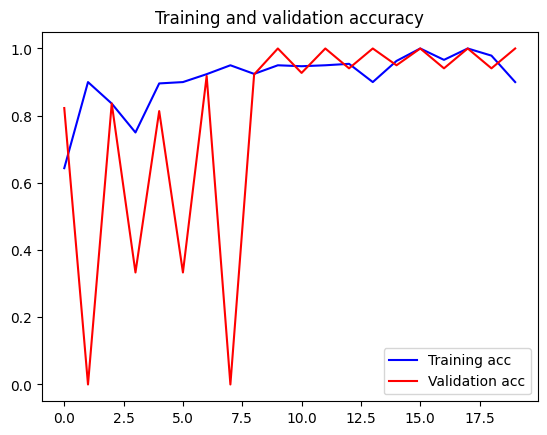

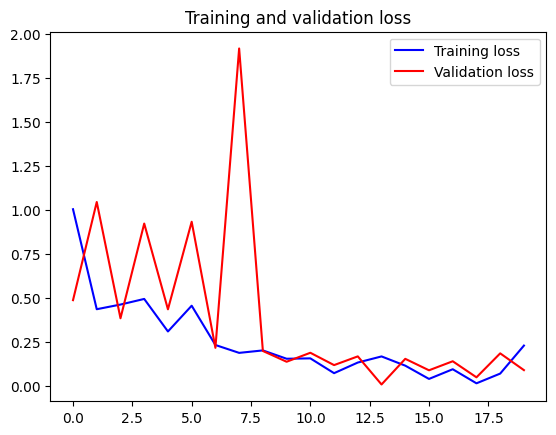

In [65]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Show the errors

In [ ]:
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (image_size, image_size),
    batch_size = val_batchsize,
    class_mode = 'categorical',
    shuffle = False)

fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

idx2label = dict((v,k) for k,v in label2index.items())

predictions = model.predict(validation_generator, verbose = 1)
predicted_classes = np.argmax(predictions, axis = 1)

errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors), validation_generator.samples))

for i in range(len(errors)):
  pred_class = np.argmax(predictions[errors[i]])
  pred_label = idx2label[pred_class]

  title = "Original label:{}, Prediction :{}, confidence: {:.3f}".format(
      fnames[errors[i]].split('/')[0],
      pred_label,
      predictions[errors[i]][pred_class]
  )

  original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))

  plt.figure(figsize = [7,7])
  plt.axis("off")
  plt.title(title)
  plt.imshow(original)
  plt.show()